In [1]:
# All the imports
import pandas as pd
import datetime
from dateutil.parser import parse
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
# Read the data from the enplaning passenger survey data
mode_choice_data = pd.read_excel("Enplaning Pax Master Survey results.xlsx", sheet_name="Combined Cleaned")

## Data Cleaning

In [3]:
# What does the df contain?
#mode_choice_data.info()

In [4]:
# Select columns that are useful 
mode_choice_data = mode_choice_data[['Surveyed Date', 'Airline', 'What is the scheduled departure time?', 
                                     'Is this a connecting flight?', 'How did you travel to the airport today? (Please select the single best answer)', 
                                     'How did you arrive by private vehicle?', 'How did you arrive by rental vehicle?', 
                                     'Did you travel to Sea-Tac Airport today by...', 'Did your immediate travel party check any bags here at Sea-Tac Airport?', 
                                     'How many bags did your immediate travel party check?', 'Is your trip today mainly for business?', 
                                     'How many carry-on items is your immediate travel party carrying on the plane?', 'Are you?', 'What year were you born?', 
                                    'What was your total annual household income before taxes in 2016?']]

In [5]:
mode_choice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10688 entries, 0 to 10687
Data columns (total 15 columns):
Surveyed Date                                                                      10688 non-null object
Airline                                                                            10674 non-null object
What is the scheduled departure time?                                              8903 non-null object
Is this a connecting flight?                                                       10677 non-null object
How did you travel to the airport today? (Please select the single best answer)    6965 non-null object
How did you arrive by private vehicle?                                             3811 non-null object
How did you arrive by rental vehicle?                                              960 non-null object
Did you travel to Sea-Tac Airport today by...                                      2020 non-null object
Did your immediate travel party check any bags here at Se

In [6]:
# Remove the rows with null values for Airline - this helps classify flight as Domestic or International 
mode_choice_data = mode_choice_data[mode_choice_data['Airline'].notnull()]
mode_choice_data.reset_index(inplace=True, drop=True)
# Classify whether Domestic or International flight - 0 - International, 1 - Domestic
#mode_choice_data['Domestic'] = ""
domestic = np.empty([len(mode_choice_data.index)], dtype='int') * np.nan
for index, row in mode_choice_data.iterrows():
    if row['Airline'] == 'Foreign Carrier':
        domestic[index] = 0
    else:
        domestic[index] = 1
mode_choice_data['Domestic'] = domestic

In [7]:
mode_choice_data.head()

,Surveyed Date,Airline,What is the scheduled departure time?,Is this a connecting flight?,How did you travel to the airport today? (Please select the single best answer),How did you arrive by private vehicle?,How did you arrive by rental vehicle?,Did you travel to Sea-Tac Airport today by...,Did your immediate travel party check any bags here at Sea-Tac Airport?,How many bags did your immediate travel party check?,Is your trip today mainly for business?,How many carry-on items is your immediate travel party carrying on the plane?,Are you?,What year were you born?,What was your total annual household income before taxes in 2016?,Domestic
0,2014-01-29 00:00:00,Foreign Carrier,NaN,No,Rental vehicle,NaN,Rental vehicle dropped me off curbside,NaN,Yes,2.0,"Yes, it is mainly for business",2.0,Male,NaN,NaN,0.0
1,2014-01-29 00:00:00,Foreign Carrier,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, it is mainly for business",1.0,Male,1953.0,"$50,000 to 74,999",0.0
2,2014-01-29 00:00:00,Foreign Carrier,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,"No, it is not mainly for business",3.0,Male,1985.0,"Less than $30,000",0.0
3,2014-01-29 00:00:00,Foreign Carrier,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, it is mainly for business",1.0,Male,1980.0,"$75,000 to $99,999",0.0
4,2014-01-29 00:00:00,Foreign Carrier,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,"No, it is not mainly for business",1.0,Female,1987.0,"$100,000 to $124,999",0.0


In [8]:
# Remove rows where flight is a connecting flight 
mode_choice_data = mode_choice_data[mode_choice_data['Is this a connecting flight?'] == 'No']
mode_choice_data.reset_index(inplace=True, drop=True)

In [9]:
# Find the number of luggage = checked bags + carry on
luggage = np.empty([len(mode_choice_data.index)], dtype='int') * np.nan
for index, row in mode_choice_data.iterrows():
    check_count = row['How many bags did your immediate travel party check?']
    carry_on_count = row['How many carry-on items is your immediate travel party carrying on the plane?']
    if pd.isna(check_count):
        checked = 0
    else:
        checked = check_count
    if pd.isna(carry_on_count):
        carry_on = 0
    else:
        carry_on = carry_on_count
    
    luggage[index] = carry_on + checked

mode_choice_data['Luggage'] = luggage

In [10]:
# Filter trips that are not business or not business
business_vals = ['Yes, it is mainly for business', 'No, it is not mainly for business']
mode_choice_data = mode_choice_data[mode_choice_data['Is your trip today mainly for business?'].isin(business_vals)]
mode_choice_data.reset_index(inplace=True, drop=True)
# Create a variable to denote whether business trip or not - 0 not business, 1 - business
business = np.empty([len(mode_choice_data.index)], dtype='int') * np.nan
for index, row in mode_choice_data.iterrows():
    if row['Is your trip today mainly for business?'] == 'Yes, it is mainly for business':
        business[index] = 1
    else:
        business[index] = 0
mode_choice_data['business'] = business

In [11]:
# clean the age column 
mode_choice_data = mode_choice_data[(mode_choice_data['What year were you born?'] > 1900) & (mode_choice_data['What year were you born?'] < 2019)]
mode_choice_data.reset_index(inplace=True, drop=True)
# Calculate the age
mode_choice_data['age'] = 2019 - mode_choice_data['What year were you born?']

In [12]:
# Clean and recategorize the ncome column 
mode_choice_data = mode_choice_data[mode_choice_data['What was your total annual household income before taxes in 2016?'].notnull()]
mode_choice_data.reset_index(inplace=True, drop=True)
income = np.empty([len(mode_choice_data.index)], dtype='int') * np.nan
for index, row in mode_choice_data.iterrows():
    income_cat = row['What was your total annual household income before taxes in 2016?'] 
    if income_cat == 'Less than $30,000':
        income[index] = 0
    elif income_cat == '$30,000 to $49,999':
        income[index] = 1
    elif income_cat == '$50,000 to 74,999':
        income[index] = 2
    elif income_cat == '$75,000 to $99,999':
        income[index] = 3
    else:
        income[index] = 4
mode_choice_data['income'] = income

In [13]:
mode_choice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 20 columns):
Surveyed Date                                                                      5900 non-null object
Airline                                                                            5900 non-null object
What is the scheduled departure time?                                              4938 non-null object
Is this a connecting flight?                                                       5900 non-null object
How did you travel to the airport today? (Please select the single best answer)    5884 non-null object
How did you arrive by private vehicle?                                             3220 non-null object
How did you arrive by rental vehicle?                                              806 non-null object
Did you travel to Sea-Tac Airport today by...                                      1699 non-null object
Did your immediate travel party check any bags here at Sea-Tac

In [14]:
# Format the date as date-time object
mode_choice_data['Date_formatted'] = pd.to_datetime(mode_choice_data['Surveyed Date'])

In [15]:
mode_choice_data['Date_formatted'].describe()

count                    5900
unique                    375
top       2016-12-18 00:00:00
freq                       43
first     2014-01-29 00:00:00
last      2019-03-26 00:00:00
Name: Date_formatted, dtype: object

In [16]:
# Get the year from the datetime column
mode_choice_data['Date_year'] = ""
mode_choice_data['Date_month'] = ""
date_year_arr = np.zeros([len(mode_choice_data.index)], dtype='int')
date_month_arr = np.zeros([len(mode_choice_data.index)], dtype='int')
#print(date_year_arr.shape)
for index, value in enumerate(mode_choice_data['Date_formatted'].tolist()):
    #print(index)
    date_year_arr[index] = int(value.year)
    date_month_arr[index] = int(value.month)
mode_choice_data['Date_year'] = date_year_arr
mode_choice_data['Date_month'] = date_month_arr

In [17]:
mode_choice_data['Date_year'].head()

0    2014
1    2014
2    2014
3    2014
4    2014
Name: Date_year, dtype: int64

In [18]:
mode_choice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 23 columns):
Surveyed Date                                                                      5900 non-null object
Airline                                                                            5900 non-null object
What is the scheduled departure time?                                              4938 non-null object
Is this a connecting flight?                                                       5900 non-null object
How did you travel to the airport today? (Please select the single best answer)    5884 non-null object
How did you arrive by private vehicle?                                             3220 non-null object
How did you arrive by rental vehicle?                                              806 non-null object
Did you travel to Sea-Tac Airport today by...                                      1699 non-null object
Did your immediate travel party check any bags here at Sea-Tac

In [19]:
# Assign a mode choice based on the mode selection 
# 0 - transit + shuttles
# 1 - Parked at SeaTac 
# 2 - Private curbside dropoffs
# 3 - TNC curbside dropoffs

df1 = mode_choice_data
df1['mode_choice_formatted'] = ""
# Only keep rows where mode choice answer not null 
df1 = df1[df1['How did you travel to the airport today? (Please select the single best answer)'].notnull()]
mode_choice_arr = np.empty([len(df1.index)], dtype='int') * np.nan
df1.reset_index(inplace=True, drop=True)
for index, row in df1.iterrows():
    #print(row)
    airport_today = row['How did you travel to the airport today? (Please select the single best answer)']
    # Case when they did travel by private vehicle or rental vehicle
    if  airport_today == 'Private vehicle (excluding Uber, Lyft, or other paid ride)':
        private_vehicle = row['How did you arrive by private vehicle?']
        if not pd.isna(private_vehicle):
            # If private vehicle dropped curbside
            if 'curbside' in private_vehicle:
                mode_choice_arr[index] = 2
            # If parked at an off-airport location
            elif 'off-airport' in private_vehicle:
                mode_choice_arr[index] = 0
            # If parked in the garage
            elif 'garage' in private_vehicle:
                mode_choice_arr[index] = 1
    # If dropped off by a rental vehicle
    elif airport_today == 'Rental vehicle':
        rental_vehicle = row['How did you arrive by rental vehicle?']
        if not pd.isna(rental_vehicle):
            # If rental car dropped at curbside
            if 'curbside' in rental_vehicle:
                mode_choice_arr[index] = 2
            # If rental car dropped at rental car facility etc.    
            else:
                mode_choice_arr[index] = 0
    elif airport_today == 'Other type of transport':
        other_mode_type = row['Did you travel to Sea-Tac Airport today by...']
        if not pd.isna(other_mode_type):
            if any(name in other_mode_type for name in ('Uber/Lyft/Other TNC', 'Taxi', 'car', 'pov', 'Limousine')):
                mode_choice_arr[index] = 3
            elif any(name in other_mode_type for name in ('Link Light Rail', 'Public transit bus (e.g., ST 560)', 'train')):
                mode_choice_arr[index] = 0
            elif any(name in other_mode_type for name in ('car2go', 'Reach Now')):
                mode_choice_arr[index] = 1
            elif any(name in other_mode_type for name in ('Shuttle Express', 'Hotel courtesy shuttle', 'Scheduled airporter bus', 'Other charter bus', 'shuttle', 'airporter bus')): 
                mode_choice_arr[index] = 0
df1['mode_choice_formatted'] = mode_choice_arr
# Remove null mode choice rows
df1 = df1[np.isfinite(df1['mode_choice_formatted'])]
mode_choice_data = df1

/home/ubuntu_cp/anaconda3/envs/keras2/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
mode_choice_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5647 entries, 0 to 5883
Data columns (total 24 columns):
Surveyed Date                                                                      5647 non-null object
Airline                                                                            5647 non-null object
What is the scheduled departure time?                                              4723 non-null object
Is this a connecting flight?                                                       5647 non-null object
How did you travel to the airport today? (Please select the single best answer)    5647 non-null object
How did you arrive by private vehicle?                                             3219 non-null object
How did you arrive by rental vehicle?                                              806 non-null object
Did you travel to Sea-Tac Airport today by...                                      1622 non-null object
Did your immediate travel party check any bags here at Sea-Tac

In [21]:
# Keep only the useful columns 
mode_choice_data = mode_choice_data[['What is the scheduled departure time?', 'Domestic', 'Luggage', 'business', 'age', 'income', 'Date_year', 'Date_month', 'mode_choice_formatted']]

In [22]:
mode_choice_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5647 entries, 0 to 5883
Data columns (total 9 columns):
What is the scheduled departure time?    4723 non-null object
Domestic                                 5647 non-null float64
Luggage                                  5647 non-null float64
business                                 5647 non-null float64
age                                      5647 non-null float64
income                                   5647 non-null float64
Date_year                                5647 non-null int64
Date_month                               5647 non-null int64
mode_choice_formatted                    5647 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 441.2+ KB


In [23]:
# Change the datatypes 
for col in ['Domestic', 'Luggage', 'business', 'income', 'Date_year', 'Date_month', 'mode_choice_formatted']:
    mode_choice_data[col] = mode_choice_data[col].astype('int').astype('category')

/home/ubuntu_cp/anaconda3/envs/keras2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
mode_choice_data['age'].describe()

count    5647.000000
mean       49.384275
std        16.540208
min        10.000000
25%        35.000000
50%        50.000000
75%        63.000000
max        95.000000
Name: age, dtype: float64

In [25]:
mode_choice_data.head()

,What is the scheduled departure time?,Domestic,Luggage,business,age,income,Date_year,Date_month,mode_choice_formatted
0,NaN,1,2,1,45.0,4,2014,1,2
1,NaN,1,2,1,52.0,4,2014,1,0
2,NaN,0,4,0,60.0,4,2014,1,0
3,NaN,0,1,0,36.0,2,2014,1,0
4,NaN,0,3,0,45.0,2,2014,1,2


In [26]:
mode_choice_data.describe()

,age
count,5647.000000
mean,49.384275
std,16.540208
min,10.000000
25%,35.000000
50%,50.000000
75%,63.000000
max,95.000000


In [27]:
# Createa separate dataframe for each year 
mode_choice_data_dfs = {}
for i in mode_choice_data['Date_year'].unique():
    mode_choice_data_dfs[str(i)] = mode_choice_data[mode_choice_data['Date_year'] == i]

In [28]:
# Collect only the mode choices for plotting 
mode_choices_df = pd.DataFrame(index=np.unique(df1['mode_choice_formatted']))   
for year in mode_choice_data_dfs:
    mode_choices_df[year] = np.unique(mode_choice_data_dfs[year]['mode_choice_formatted'], return_counts=True)[1] * 100 /  len(mode_choice_data_dfs[year].index)

In [29]:
mode_choices_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4 entries, 0.0 to 3.0
Data columns (total 6 columns):
2014    4 non-null float64
2015    4 non-null float64
2016    4 non-null float64
2017    4 non-null float64
2018    4 non-null float64
2019    4 non-null float64
dtypes: float64(6)
memory usage: 224.0 bytes


In [30]:
mode_choices_df.reset_index(inplace=True)

In [31]:
mode_choices_df

,index,2014,2015,2016,2017,2018,2019
0,0.0,42.954856,45.584046,38.875306,39.616858,38.859715,32.378223
1,1.0,7.660739,7.834758,9.372453,7.126437,7.501875,6.876791
2,2.0,38.440492,36.324786,41.564792,40.766284,40.810203,45.558739
3,3.0,10.943912,10.256410,10.187449,12.490421,12.828207,15.186246


In [32]:
mode_choice_df = mode_choices_df.melt('index', var_name='year', value_name='count')

In [33]:
mode_choice_df

,index,year,count
0,0.0,2014,42.954856
1,1.0,2014,7.660739
2,2.0,2014,38.440492
3,3.0,2014,10.943912
4,0.0,2015,45.584046
5,1.0,2015,7.834758
6,2.0,2015,36.324786
7,3.0,2015,10.256410
8,0.0,2016,38.875306
9,1.0,2016,9.372453


In [34]:
sns.set_context('talk')

[Text(0, 0.5, 'Percent share'),
 [Text(0, 0, 'Transit+'),
  Text(0, 0, 'Parked'),
  Text(0, 0, 'Curbside'),
  Text(0, 0, 'TNC+')],
 Text(0.5, 0, 'Modes')]

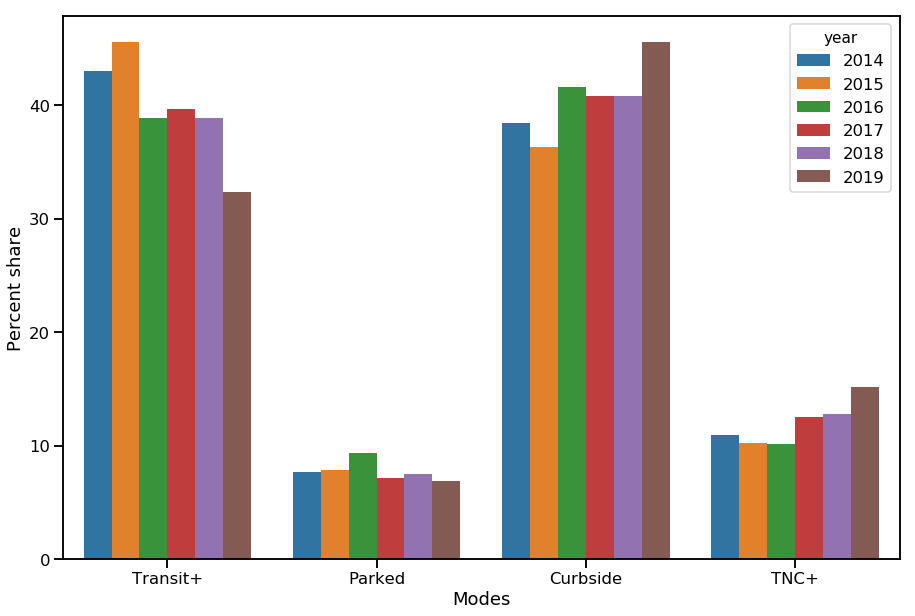

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.barplot(x = mode_choice_df['index'], y = mode_choice_df['count'], hue=mode_choice_df['year'], ax=ax)
ax.set(xlabel="Modes", ylabel="Percent share", xticklabels=["Transit+", "Parked", "Curbside", "TNC+"])
#ax.legend(labels=["Actual data from 1990-2018", "LSTM Forecast", "Official Forecast"])

# Perform the modeling 

In [36]:
mul_lr_results =  {}
svc_results = {}
dt_results = {}
rfc_results = {}
keras_results = {}
gbm_results = {}

In [37]:
df1 = mode_choice_data_dfs['2014']

In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 0 to 762
Data columns (total 9 columns):
What is the scheduled departure time?    0 non-null object
Domestic                                 731 non-null category
Luggage                                  731 non-null category
business                                 731 non-null category
age                                      731 non-null float64
income                                   731 non-null category
Date_year                                731 non-null category
Date_month                               731 non-null category
mode_choice_formatted                    731 non-null category
dtypes: category(7), float64(1), object(1)
memory usage: 24.8+ KB


In [39]:
df1['mode_choice_formatted'].describe()

count     731
unique      4
top         0
freq      314
Name: mode_choice_formatted, dtype: int64

## Preparing for regression

In [40]:
# Get X, y 
X = df1[['Domestic', 'Luggage', 'business', 'age', 'income', 'Date_month']]
y = df1[['mode_choice_formatted']]


In [41]:
X.head()

,Domestic,Luggage,business,age,income,Date_month
0,1,2,1,45.0,4,1
1,1,2,1,52.0,4,1
2,0,4,0,60.0,4,1
3,0,1,0,36.0,2,1
4,0,3,0,45.0,2,1


In [42]:
# Scale the age variable
scaler = MinMaxScaler()
X['age'] = scaler.fit_transform(X['age'].to_numpy().reshape(-1,1)).ravel()

/home/ubuntu_cp/anaconda3/envs/keras2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
X['age'].head()

0    0.342105
1    0.434211
2    0.539474
3    0.223684
4    0.342105
Name: age, dtype: float64

In [44]:
X['age'].head()

0    0.342105
1    0.434211
2    0.539474
3    0.223684
4    0.342105
Name: age, dtype: float64

In [45]:
# Create the test-train split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)
X_train.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)

In [46]:
X_train.head()

,Domestic,Luggage,business,age,income,Date_month
0,1,3,0,0.118421,3,11
1,1,3,0,0.197368,4,5
2,1,1,0,0.421053,2,5
3,1,2,1,0.407895,4,5
4,1,4,0,0.078947,2,8


In [47]:
X_test.head()

,Domestic,Luggage,business,age,income,Date_month
734,1,2,1,0.394737,4,11
35,1,1,0,0.118421,0,2
311,1,3,0,0.618421,0,5
478,1,2,0,0.526316,1,8
663,1,2,1,0.578947,3,11


In [48]:
# Create a model object
mul_lr_df1 = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, np.ravel(y_train))

In [49]:
type(X_train)

pandas.core.frame.DataFrame

In [50]:
mul_lr_score = mul_lr_df1.score(X_train, np.ravel(y_train))

In [51]:
mul_lr_predict = mul_lr_df1.predict(X_test)

In [52]:
mul_lr_results[2014] = {
    "score": mul_lr_score, 
    "predict": mul_lr_predict
    }

In [53]:
svc_df1 =  SVC(gamma='auto')

In [54]:
svc_df1.fit(X_train, np.ravel(y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
svc_score = svc_df1.score(X_train, np.ravel(y_train))

In [56]:
svc_predict = svc_df1.predict(X_test)

In [57]:
svc_results[2014] = {
    "score": svc_score, 
    "predict": svc_predict
    }

In [58]:
rfc_df1 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

In [59]:
rfc_df1.fit(X_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [60]:
rfc_score = rfc_df1.score(X_train, np.ravel(y_train))

In [61]:
rfc_predict = rfc_df1.predict(X_test)

In [62]:
rfc_results[2014] = {
    "score": rfc_score, 
    "predict": rfc_predict
    }

In [63]:
gbm_df1 = GradientBoostingClassifier(random_state=10)

In [64]:
gbm_df1.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [65]:
gbm_score = gbm_df1.score(X_train, np.ravel(y_train))

In [66]:
gbm_predict = gbm_df1.predict(X_test)

In [67]:
gbm_results[2014] = {
    "score": gbm_score, 
    "predict": gbm_predict
    }

In [68]:
dt_df1 = tree.DecisionTreeClassifier(max_depth=100)

In [ ]:
dt_df1 = dt_df1.fit(X_train, np.ravel(y_train))

In [ ]:
dt_score = dt_df1.score(X_train, np.ravel(y_train))

In [ ]:
dt_predict = dt_df1.predict(X_test)

In [ ]:
dt_results[2014] = {
    "score": dt_score, 
    "predict": dt_predict
    }

## Trying Keras 

In [ ]:
dummy_y = np_utils.to_categorical(y, num_classes=4)

In [ ]:
dummy_y

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
seed = 7
np.random.seed(seed)

In [ ]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(5, input_dim=input_dim, init='normal', activation='relu'))
	model.add(Dense(4, init='normal', activation='sigmoid'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=200, verbose=0)
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), dummy_y, test_size=0.2, random_state=seed)

In [ ]:
input_dim = X.shape[1]

In [ ]:
#X_train = np.array(X_train)

In [ ]:
input_dim

6

In [ ]:
model = Sequential()
model.add(Dense(250, input_shape=(input_dim,) , activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

hist = model.fit(X_train, Y_train, epochs = 5000, verbose=0)

#scores = model.evaluate(X_test, Y_test)
#print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
keras_score = hist.history.get('acc')[-1]

In [ ]:
keras_predict = model.predict_classes(X_test)

In [ ]:
keras_predict

In [ ]:
keras_results[2014] = {
    "score": keras_score, 
    "predict": keras_predict
    }

## Perform the modeling and prediction for other years

In [ ]:
df1 = mode_choice_data_dfs['2015']

In [ ]:
X = df1[['Domestic', 'Luggage', 'business', 'age', 'income', 'Date_month', 'What is the scheduled departure time?']]

In [ ]:
X.info()

In [ ]:
X['Departure_time'] = pd.to_datetime(X['What is the scheduled departure time?'], format="%H:%M:%S")

In [ ]:
#X['Departure_time'] = X['Departure_time'].astype(np.int64)

In [ ]:
X['Departure_time'].head()

In [ ]:
#X['Departure_time'] = X['Departure_time'].round(180)

In [ ]:
def roundTime(dt=None, dateDelta=datetime.timedelta(minutes=1)):
    """Round a datetime object to a multiple of a timedelta
    dt : datetime.datetime object, default now.
    dateDelta : timedelta object, we round to a multiple of this, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
            Stijn Nevens 2014 - Changed to use only datetime objects as variables
    """
    roundTo = dateDelta.total_seconds()

    if dt == None : dt = datetime.datetime.now()
    seconds = (dt - dt.min).seconds
    # // is a floor division, not a comment on following line:
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

In [ ]:
roundTime(X['Departure_time'].iloc[0], datetime.timedelta(hours=6))

In [ ]:
X['Departure_time'].iloc[0].hour

In [ ]:
X.head()

In [ ]:
for year in mode_choice_data_dfs:
    # 2014 modeled separately, as it doesnt have the departure time feature
    if year == 2014:
        continue
    else: 
        df1 = mode_choice_data_dfs[year]
        # Get X, y 
        X = df1[['Domestic', 'Luggage', 'business', 'age', 'income', 'Date_month']]
        y = df1[['mode_choice_formatted']]
        # Remove any rows with NA in them, and then reset index
        X = X.dropna()
        X.reset_index(inplace=True, drop=True)
        # Scale the age, to be a number between 0 and 1 
        # Scale the age variable
        scaler = MinMaxScaler()
        X['age'] = scaler.fit_transform(X['age'].to_numpy().reshape(-1,1)).ravel()
        # Create the test-train split
        X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.2, random_state=42)
        X_train.reset_index(inplace=True, drop=True)
        X_test.reset_index(inplace=True, drop=True)
        # Perform Multinomial Regression
        mul_lr_df1 = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, np.ravel(y_train))
        mul_lr_score = mul_lr_df1.score(X_train, np.ravel(y_train))
        mul_lr_predict = mul_lr_df1.predict(X_test)
        mul_lr_test_score = mul_lr_df1.score(X_test, np.ravel(y_test))
        mul_lr_results[year] = {
        "score": mul_lr_score, 
        "test_score": mul_lr_test_score,
        "predict": mul_lr_predict
        }
        # Perform classification through SVM 
        svc_df1 =  SVC(gamma='auto')
        svc_df1.fit(X_train, np.ravel(y_train))
        svc_score = svc_df1.score(X_train, np.ravel(y_train))
        svc_predict = svc_df1.predict(X_test)
        svc_test_score = svc_df1.score(X_test, np.ravel(y_test))
        svc_results[year] = {
        "score": svc_score,
        "test_score": svc_test_score,
        "predict": svc_predict
        }
        # Perform Random Forest Classification
        rfc_df1 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
        rfc_df1.fit(X_train, np.ravel(y_train))
        rfc_score = rfc_df1.score(X_train, np.ravel(y_train))
        rfc_predict = rfc_df1.predict(X_test)
        rfc_test_score = rfc_df1.score(X_test, np.ravel(y_test))
        rfc_results[year] = {
        "score": rfc_score,
        "test_score": rfc_test_score,    
        "predict": rfc_predict
        }
        # Perform gradient boosting
        gbm_df1 = GradientBoostingClassifier(random_state=10)
        gbm_df1.fit(X_train, np.ravel(y_train))
        gbm_score = gbm_df1.score(X_train, np.ravel(y_train))
        gbm_predict = gbm_df1.predict(X_test)
        gbm_test_score = gbm_df1.score(X_test, np.ravel(y_test))
        gbm_results[year] = {
        "score": gbm_score,
        "test_score": gbm_test_score,
        "predict": gbm_predict
        }
        # Perform Decision Tree Classification
        dt_df1 = tree.DecisionTreeClassifier(max_depth=100)
        dt_df1 = dt_df1.fit(X_train, np.ravel(y_train))
        dt_score = dt_df1.score(X_train, np.ravel(y_train))
        dt_predict = dt_df1.predict(X_test)
        dt_test_score = dt_df1.score(X_test, np.ravel(y_test))
        dt_results[year] = {
        "score": dt_score,
        "test_score": dt_test_score,
        "predict": dt_predict
        }
        # Keras 
        # Convert y to one-hot encoding
        dummy_y = np_utils.to_categorical(y, num_classes=4)
        X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), dummy_y, test_size=0.2, random_state=seed)
        seed = 7
        input_dim = X_train.shape[1]
        np.random.seed(seed)
        model = Sequential()
        model.add(Dense(250, input_shape=(input_dim,) , activation = 'relu'))
        model.add(Dense(250, activation = 'relu'))
        model.add(Dense(250, activation = 'relu'))
        model.add(Dense(250, activation = 'relu'))
        model.add(Dense(4, activation = 'softmax'))
        model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )
        hist = model.fit(X_train, Y_train, epochs = 2000, verbose=0)
        keras_score = hist.history.get('acc')[-1]
        keras_predict = model.predict_classes(X_test)
        score, acc = model.evaluate(X_test, Y_test)
        keras_test_score = acc
        keras_results[year] = {
        "score": keras_score,
        "test_score": keras_test_score,
        "predict": keras_predict
        }

In [ ]:
mul_lr_results

In [ ]:
dt_results

In [ ]:
gbm_results

In [ ]:
keras_results

In [ ]:
rfc_results

In [ ]:
svc_results

In [ ]:
mul_lr_scores = []
dt_scores = []
rfc_scores = []
gbm_scores = []
svc_scores = []
keras_scores = []

for year in mul_lr_results:
    mul_lr_scores.append(mul_lr_results[year]['score'])
    dt_scores.append(dt_results[year]['score'])
    gbm_scores.append(gbm_results[year]['score'])
    rfc_scores.append(rfc_results[year]['score'])
    svc_scores.append(svc_results[year]['score'])
    keras_scores.append(keras_results[year]['score'])

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.lineplot(x=list(mul_lr_results.keys()), y=mul_lr_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(dt_results.keys()), y=dt_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(svc_results.keys()), y=svc_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(gbm_results.keys()), y=gbm_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(rfc_results.keys()), y=rfc_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(keras_results.keys()), y=keras_scores, markers=True, dashes=True, ax=ax)
ax.set(xlabel="Years", ylabel="Accuracy (Score)")
ax.legend(labels=["Multinomial Logistic Regression", "Decision Tree", "Support Vector Machine", 
                   "Gradient Boosting Machine", "Random Forest", "Keras (Tensorflow)"])

In [ ]:
print(a)

In [ ]:
mul_lr_df1.coef_

In [ ]:
mul_lr_df1.intercept_

In [ ]:
for i in range(mul_lr_df1.coef_.shape[0]):
    sns.barplot(x=[range(0,6)],y=mul_lr_df1.coef_[:][i])


In [ ]:
mul_lr_results

In [ ]:
# mul_lr_results = mul_lr_results_copy = mul_lr_results 
svc_results_copy = svc_results 
dt_results_copy = dt_results 
gbm_results_copy = gbm_results 
rfc_results_copy = rfc_results 
keras_results_copy = keras_results 

In [ ]:
mul_lr_results_copy

In [ ]:
mul_lr_results

In [ ]:
mul_lr_test_scores = []
dt_test_scores = []
rfc_test_scores = []
gbm_test_scores = []
svc_test_scores = []
keras_test_scores = []

for year in mul_lr_results:
    if year == '2014': 
        continue
    else:
        print(year)
        mul_lr_test_scores.append(mul_lr_results[year]['test_score'])
        dt_test_scores.append(dt_results[year]['test_score'])
        gbm_test_scores.append(gbm_results[year]['test_score'])
        rfc_test_scores.append(rfc_results[year]['test_score'])
        svc_test_scores.append(svc_results[year]['test_score'])
        keras_test_scores.append(keras_results[year]['test_score'])

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.lineplot(x=list(mul_lr_results.keys()), y=mul_lr_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(dt_results.keys()), y=dt_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(svc_results.keys()), y=svc_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(gbm_results.keys()), y=gbm_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(rfc_results.keys()), y=rfc_scores, markers=True, dashes=True, ax=ax)
sns.lineplot(x=list(keras_results.keys()), y=keras_scores, markers=True, dashes=True, ax=ax)
ax.set(xlabel="Years", ylabel="Accuracy (Score)")
ax.legend(labels=["Multinomial Logistic Regression", "Decision Tree", "Support Vector Machine", 
                   "Gradient Boosting Machine", "Random Forest", "Keras (Tensorflow)"])